In [1]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.preprocessing import  StandardScaler, LabelEncoder, OneHotEncoder, LabelBinarizer, MinMaxScaler
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform
import tensorflow as tf

from keras.models import Sequential,load_model
from keras.layers import Dense, LSTM, SimpleRNN, Dropout, GaussianNoise, Activation
from keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical 
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
#data function for reading and processing the train and test sets
#necessary as an input for the optimisation algorithm
def data():
    #define input processing function
    def process_attributes(df, train, test):
        
        #define and fit the scaler to the full dataset
        cs = MinMaxScaler()
        cs.fit(df_inputs.select_dtypes(np.number))
        
        #scale the numerical input variables
        trainContinuous = cs.transform(train.select_dtypes(np.number))
        testContinuous = cs.transform(test.select_dtypes(np.number))
        
        if 'Gender' in df.columns:
            
            #uncomment the code below to accommodate for any categorical columns
            zipBinarizer = LabelBinarizer().fit(df["Gender"])
            trainCategorical = zipBinarizer.transform(train["Gender"])
            testCategorical = zipBinarizer.transform(test["Gender"])

            # construct our training and testing data points by concatenating
            # the categorical features with the continuous features
            trainX = np.hstack([trainContinuous, trainCategorical])
            testX = np.hstack([testContinuous, testCategorical])
            
        else:
            trainX=trainContinuous
            testX=testContinuous
        
        # return the concatenated training and testing data
        return (trainX, testX)
    
    #read the excel datasets
    df = pd.read_excel('Cleaned_Dataframe_1298_datapoints.xlsx')
    df.set_index('Sample',inplace=True)
    features=df.columns

    df_cancer = df.loc[df['Status'] == 'Cancer']
    df_control = df.loc[df['Status'] == 'Control']

    #randomly seelct 538 samples from the cancer population to create an equal sample size 
    df_cancer_small = df_cancer.sample(n=538, random_state = 100)

    df1 = pd.concat([df_cancer_small, df_control])
    #separate cancer markers and input data
    df_outputs= df1['Status']
    df_inputs = df1.drop(['Status'],axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(df_inputs, df_outputs, random_state=100, stratify=df_outputs, test_size=0.3)
    
    #process the input sets
    (X_train_sc, X_test_sc) = process_attributes(df_inputs, X_train, X_test)
    
    #encode the categorical output variables
    #encode categorical outputs
    lb = LabelBinarizer()
    lb.fit(y_train)
    train_outputs= lb.transform(y_train)
    test_outputs= lb.transform(y_test)

    Y_train = tf.keras.utils.to_categorical(train_outputs)
    Y_test = tf.keras.utils.to_categorical(test_outputs)

    return X_train_sc, Y_train, X_test_sc, Y_test, lb, features

In [3]:
#define model and search space for the optimisation algorithm
def model(X_train_sc, Y_train, X_test_sc, Y_test):
    
    #define ANN model and search space
    def ANN():
        
        #define first two layers, possible alternatives for neurons in each,
        #activation function, and dropout layers
        model=Sequential()
        Dropout_rate={{uniform(0, 0.3)}}
        model.add(Dense({{choice([8,16, 24, 32, 64])}}))
        model.add(Activation({{choice(['relu', 'sigmoid', 'tanh'])}}))

        model.add(Dropout(Dropout_rate))

        model.add(Dense({{choice([8,16, 24, 32, 64])}}))
        model.add(Activation({{choice(['relu', 'sigmoid', 'tanh'])}}))

        model.add(Dropout(Dropout_rate))
        
        #define output layer of the model
        
        model.add(Dense(2))
        model.add(Activation('softmax'))
        
        #define optimisation algorithm for network training
        optim=tf.keras.optimizers.Adam(learning_rate={{choice([ 0.001, 0.0005, 0.0001])}})
        
        #compile model and return it
        model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=optim)
        
        return model 
    
    #encode and transform labels for model training
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(np.argmax(Y_train,axis=1))
    
    #call the ANN and ddefine training epochs; define batch size alternatives
    net = KerasClassifier(build_fn = ANN,
                                 epochs={{choice([50,100,200])}},
                                 batch_size= {{choice([32,64])}},
                                 verbose = 0)
    model = ANN()
    
    #set up cross-validation scoring, and returned variables
    c = cross_val_score(net,
                    X_train_sc, y,
                    cv= StratifiedKFold(n_splits=5, shuffle=True),
                    scoring='accuracy').mean()
    print('Test accuracy:', c)
    return {'loss': -c, 'status': STATUS_OK, 'model': model}

In [4]:
#call in data function for test evaluation later
X_train, Y_train, X_test, Y_test, lb, features = data()
print('The model uses the following features:', features)

The model uses the following features: Index(['GP1', 'GP2', 'GP3', 'GP4', 'GP5', 'GP6', 'GP7', 'GP8', 'GP9', 'GP10',
       'GP11', 'GP12', 'GP13', 'GP14', 'GP15', 'GP16', 'GP17', 'GP18', 'GP19',
       'GP20', 'GP21', 'GP22', 'GP23', 'GP24', 'Gender', 'Age at sample',
       'Status'],
      dtype='object')


In [7]:
#call the optimisation algorithm
best_run, best_model = optim.minimize(model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=50,
                                      trials=Trials(),
                                      notebook_name='ANN_Optimisation_Balanced_StudySubset')

>>> Imports:
#coding=utf-8

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    from sklearn.pipeline import Pipeline
except:
    pass

try:
    from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
except:
    pass

try:
    from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, LabelBinarizer, MinMaxScaler
except:
    pass

try:
    from sklearn.compose import make_column_selector as selector
except:
    pass

try:
    from sklearn.compose import ColumnTransformer
except:
    pass

try:
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
    from hyperas.distributions import choice, uniform
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    from keras.models 

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                        
0.7132008830022075                                    
  2%|▏         | 1/50 [01:14<1:00:45, 74.39s/trial, best loss: -0.7132008830022075]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '



Test accuracy:                                                                     
0.7237792494481237                                                                 
  4%|▍         | 2/50 [02:01<46:43, 58.41s/trial, best loss: -0.7237792494481237]  

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.7303664459161147                                                               
  6%|▌         | 3/50 [02:53<43:34, 55.62s/trial, best loss: -0.7303664459161147]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.7384017660044151                                                               
  8%|▊         | 4/50 [03:21<34:11, 44.61s/trial, best loss: -0.7384017660044151]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.7675673289183224                                                               
 10%|█         | 5/50 [03:57<31:10, 41.56s/trial, best loss: -0.7675673289183224]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.7316997792494481                                                               
 12%|█▏        | 6/50 [04:31<28:26, 38.78s/trial, best loss: -0.7675673289183224]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.725130242825607                                                                
 14%|█▍        | 7/50 [04:48<22:45, 31.76s/trial, best loss: -0.7675673289183224]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.6149403973509934                                                               
 16%|█▌        | 8/50 [05:05<18:59, 27.12s/trial, best loss: -0.7675673289183224]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.7304459161147904                                                               
 18%|█▊        | 9/50 [05:38<19:44, 28.88s/trial, best loss: -0.7675673289183224]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                   
0.729112582781457                                                                
 20%|██        | 10/50 [05:56<17:02, 25.57s/trial, best loss: -0.7675673289183224]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.727841059602649                                                                 
 22%|██▏       | 11/50 [06:28<17:57, 27.62s/trial, best loss: -0.7675673289183224]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7197880794701987                                                                
 24%|██▍       | 12/50 [06:47<15:41, 24.77s/trial, best loss: -0.7675673289183224]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.744980132450331                                                                 
 26%|██▌       | 13/50 [07:12<15:26, 25.05s/trial, best loss: -0.7675673289183224]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7516909492273731                                                                
 28%|██▊       | 14/50 [07:37<14:55, 24.87s/trial, best loss: -0.7675673289183224]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.6879028697571743                                                                
 30%|███       | 15/50 [07:56<13:29, 23.13s/trial, best loss: -0.7675673289183224]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7184547461368653                                                                
 32%|███▏      | 16/50 [08:20<13:18, 23.47s/trial, best loss: -0.7675673289183224]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7144724061810154                                                                
 34%|███▍      | 17/50 [08:38<11:55, 21.68s/trial, best loss: -0.7675673289183224]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7383311258278145                                                                
 36%|███▌      | 18/50 [08:54<10:40, 20.03s/trial, best loss: -0.7675673289183224]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.751673289183223                                                                 
 38%|███▊      | 19/50 [09:12<10:02, 19.45s/trial, best loss: -0.7675673289183224]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7529801324503311                                                                
 40%|████      | 20/50 [09:45<11:44, 23.50s/trial, best loss: -0.7675673289183224]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7529713024282562                                                                
 42%|████▏     | 21/50 [10:12<11:51, 24.53s/trial, best loss: -0.7675673289183224]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7051743929359823                                                                
 44%|████▍     | 22/50 [10:36<11:24, 24.44s/trial, best loss: -0.7675673289183224]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7716291390728477                                                                
 46%|████▌     | 23/50 [11:13<12:43, 28.28s/trial, best loss: -0.7716291390728477]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7609271523178808                                                                
 48%|████▊     | 24/50 [11:39<11:56, 27.55s/trial, best loss: -0.7716291390728477]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7768741721854304                                                                
 50%|█████     | 25/50 [12:13<12:15, 29.43s/trial, best loss: -0.7768741721854304]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.738401766004415                                                                 
 52%|█████▏    | 26/50 [12:46<12:09, 30.41s/trial, best loss: -0.7768741721854304]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7557174392935982                                                                
 54%|█████▍    | 27/50 [13:19<12:01, 31.37s/trial, best loss: -0.7768741721854304]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7503576158940397                                                                
 56%|█████▌    | 28/50 [13:51<11:35, 31.63s/trial, best loss: -0.7768741721854304]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7570507726269317                                                                
 58%|█████▊    | 29/50 [14:29<11:38, 33.27s/trial, best loss: -0.7768741721854304]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7489977924944812                                                                
 60%|██████    | 30/50 [15:04<11:21, 34.05s/trial, best loss: -0.7768741721854304]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7556997792494481                                                                
 62%|██████▏   | 31/50 [15:38<10:43, 33.88s/trial, best loss: -0.7768741721854304]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7596644591611479                                                                
 64%|██████▍   | 32/50 [16:10<10:01, 33.41s/trial, best loss: -0.7768741721854304]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.6428079470198675                                                                
 66%|██████▌   | 33/50 [16:40<09:08, 32.28s/trial, best loss: -0.7768741721854304]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7582869757174393                                                                
 68%|██████▊   | 34/50 [17:13<08:38, 32.44s/trial, best loss: -0.7768741721854304]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7543752759381899                                                                
 70%|███████   | 35/50 [17:47<08:15, 33.03s/trial, best loss: -0.7768741721854304]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7596291390728477                                                                
 72%|███████▏  | 36/50 [18:21<07:44, 33.16s/trial, best loss: -0.7768741721854304]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.6639999999999999                                                                
 74%|███████▍  | 37/50 [18:44<06:34, 30.38s/trial, best loss: -0.7768741721854304]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7755849889624724                                                                
 76%|███████▌  | 38/50 [19:17<06:14, 31.17s/trial, best loss: -0.7768741721854304]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7289801324503312                                                                
 78%|███████▊  | 39/50 [19:36<04:59, 27.26s/trial, best loss: -0.7768741721854304]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.73839293598234                                                                  
 80%|████████  | 40/50 [20:07<04:44, 28.47s/trial, best loss: -0.7768741721854304]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7529977924944813                                                                
 82%|████████▏ | 41/50 [20:45<04:41, 31.30s/trial, best loss: -0.7768741721854304]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.731682119205298                                                                 
 84%|████████▍ | 42/50 [21:07<03:49, 28.63s/trial, best loss: -0.7768741721854304]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7463399558498897                                                                
 86%|████████▌ | 43/50 [21:26<03:00, 25.73s/trial, best loss: -0.7768741721854304]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7396909492273731                                                                
 88%|████████▊ | 44/50 [22:04<02:56, 29.46s/trial, best loss: -0.7768741721854304]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7316379690949227                                                                
 90%|█████████ | 45/50 [22:39<02:35, 31.02s/trial, best loss: -0.7768741721854304]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7423222958057394                                                                
 92%|█████████▏| 46/50 [22:57<01:48, 27.04s/trial, best loss: -0.7768741721854304]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7211037527593819                                                                
 94%|█████████▍| 47/50 [23:16<01:13, 24.60s/trial, best loss: -0.7768741721854304]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7555849889624724                                                                
 96%|█████████▌| 48/50 [23:50<00:55, 27.57s/trial, best loss: -0.7768741721854304]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.7198587196467992                                                                
 98%|█████████▊| 49/50 [24:16<00:27, 27.01s/trial, best loss: -0.7768741721854304]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid

Test accuracy:                                                                    
0.6295982339955849                                                                
100%|██████████| 50/50 [24:34<00:00, 29.48s/trial, best loss: -0.7768741721854304]


In [8]:
#display the parameters for the best performing model
print(best_run)

{'Activation': 0, 'Activation_1': 0, 'Dense': 3, 'Dense_1': 2, 'Dropout_rate': 0.2588599215830666, 'batch_size': 0, 'epochs': 2, 'learning_rate': 0}


In [9]:
best_model

In [10]:
#train the model to gt learning curves
batch=[32,64]
ep=[50,100,200]

history = best_model.fit(
    X_train, Y_train,
    batch_size=batch[best_run['batch_size']],
    epochs=ep[best_run['epochs']],
    verbose=1,
    validation_data=(X_test, Y_test),
    shuffle=False)

Epoch 1/200
24/24 [==============================] - 3s 47ms/step - loss: 0.6945 - accuracy: 0.5631 - val_loss: 0.6778 - val_accuracy: 0.6471
Epoch 2/200
24/24 [==============================] - 0s 6ms/step - loss: 0.6945 - accuracy: 0.5167 - val_loss: 0.6652 - val_accuracy: 0.6904
Epoch 3/200
24/24 [==============================] - 0s 5ms/step - loss: 0.6637 - accuracy: 0.6302 - val_loss: 0.6500 - val_accuracy: 0.7090
Epoch 4/200
24/24 [==============================] - 0s 6ms/step - loss: 0.6560 - accuracy: 0.6294 - val_loss: 0.6353 - val_accuracy: 0.7028
Epoch 5/200
24/24 [==============================] - 0s 6ms/step - loss: 0.6348 - accuracy: 0.6702 - val_loss: 0.6160 - val_accuracy: 0.7245
Epoch 6/200
24/24 [==============================] - 0s 5ms/step - loss: 0.6162 - accuracy: 0.6822 - val_loss: 0.5960 - val_accuracy: 0.7214
Epoch 7/200
24/24 [==============================] - 0s 5ms/step - loss: 0.6001 - accuracy: 0.6970 - val_loss: 0.5792 - val_accuracy: 0.7430
Epoch 8/200


Epoch 59/200
24/24 [==============================] - 0s 3ms/step - loss: 0.4485 - accuracy: 0.7816 - val_loss: 0.5049 - val_accuracy: 0.7585
Epoch 60/200
24/24 [==============================] - 0s 3ms/step - loss: 0.4557 - accuracy: 0.7586 - val_loss: 0.5049 - val_accuracy: 0.7585
Epoch 61/200
24/24 [==============================] - 0s 3ms/step - loss: 0.4421 - accuracy: 0.7881 - val_loss: 0.5036 - val_accuracy: 0.7585
Epoch 62/200
24/24 [==============================] - 0s 3ms/step - loss: 0.4401 - accuracy: 0.7732 - val_loss: 0.5052 - val_accuracy: 0.7616
Epoch 63/200
24/24 [==============================] - 0s 3ms/step - loss: 0.4481 - accuracy: 0.7818 - val_loss: 0.5059 - val_accuracy: 0.7616
Epoch 64/200
24/24 [==============================] - 0s 3ms/step - loss: 0.4300 - accuracy: 0.8043 - val_loss: 0.5067 - val_accuracy: 0.7523
Epoch 65/200
24/24 [==============================] - 0s 3ms/step - loss: 0.4443 - accuracy: 0.7862 - val_loss: 0.5035 - val_accuracy: 0.7554
Epoch 

24/24 [==============================] - 0s 3ms/step - loss: 0.3622 - accuracy: 0.8213 - val_loss: 0.5433 - val_accuracy: 0.7523
Epoch 174/200
24/24 [==============================] - 0s 2ms/step - loss: 0.3611 - accuracy: 0.8296 - val_loss: 0.5237 - val_accuracy: 0.7523
Epoch 175/200
24/24 [==============================] - 0s 3ms/step - loss: 0.3786 - accuracy: 0.8320 - val_loss: 0.5392 - val_accuracy: 0.7492
Epoch 176/200
24/24 [==============================] - 0s 2ms/step - loss: 0.3639 - accuracy: 0.8356 - val_loss: 0.5344 - val_accuracy: 0.7492
Epoch 177/200
24/24 [==============================] - 0s 2ms/step - loss: 0.3665 - accuracy: 0.8239 - val_loss: 0.5273 - val_accuracy: 0.7554
Epoch 178/200
24/24 [==============================] - 0s 3ms/step - loss: 0.3693 - accuracy: 0.8199 - val_loss: 0.5490 - val_accuracy: 0.7554
Epoch 179/200
24/24 [==============================] - 0s 2ms/step - loss: 0.3617 - accuracy: 0.8252 - val_loss: 0.5568 - val_accuracy: 0.7585
Epoch 180/200

In [11]:
#save resulting model in callable file
best_model.summary()
best_model.save('ANN Models/all_inputs_balanced_studysubset_model.h5')
print("Saved model to directory")

Model: "sequential_144"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_432 (Dense)            (None, 32)                864       
_________________________________________________________________
activation_432 (Activation)  (None, 32)                0         
_________________________________________________________________
dropout_288 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_433 (Dense)            (None, 24)                792       
_________________________________________________________________
activation_433 (Activation)  (None, 24)                0         
_________________________________________________________________
dropout_289 (Dropout)        (None, 24)                0         
_________________________________________________________________
dense_434 (Dense)            (None, 2)              

In [12]:
#Calculate the labels for the test set
predictions = best_model.predict(X_test)

In [13]:
#evaluate test performance of the model
print('Cancer is encoded by',lb.transform(['Cancer']), ', while Control is encoded by',lb.transform(['Control']))
print(confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(predictions, axis=1)))
print(classification_report(np.argmax(Y_test, axis=1), np.argmax(predictions, axis=1), target_names=lb.classes_))

Cancer is encoded by [[0]] , while Control is encoded by [[1]]
[[105  57]
 [ 18 143]]
              precision    recall  f1-score   support

      Cancer       0.85      0.65      0.74       162
     Control       0.71      0.89      0.79       161

    accuracy                           0.77       323
   macro avg       0.78      0.77      0.76       323
weighted avg       0.78      0.77      0.76       323



In [14]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


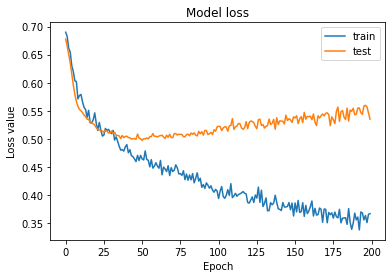

In [15]:
from matplotlib import pyplot as plt
# Visualize history
# Plot history: Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

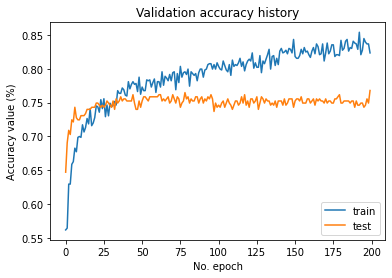

In [16]:
# Plot history: Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()